Importing all of the necessary modules. My algorithms of choice for this notebook are XGBoost and polynomial regression. I chose XGBoost because it was the top performing model in my original proposal task. I also wanted to use a model that's not based on decision trees, so I went with poly.


In [ ]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb 

from sklearn.metrics import *
from skimage.filters import gaussian

I'm using Google Drive to store the data. In my head, it's debatable whether this is the best choice or not but it'll do for now.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Random seed so we can always receive the random numbers.

In [ ]:
np.random.seed(42)

Below are some helper functions for printing various graphs, splitting maps and scoring the results. These helper functions are hidden by default in order to save some space.

## Helper functions (collapsed/hidden by default)

In [ ]:
#@title
def map_splitter(map_):
    '''Splits input map in two and returns the two halves as FLATTENED dataframes'''
    half_maps = np.hsplit(map_, 2) # split numpy array in two pieces
    left = pd.DataFrame(half_maps[0].flatten()) # we need to flatten each piece in order to process it later on
    right = pd.DataFrame(half_maps[1].flatten()) # turning them into pd.dataframes will help us later on

    return left, right

In [ ]:
#@title
def map_scoring(y_test, preds, verbose=True, plots=True):
    
    residuals = y_test - preds
    mse = mean_squared_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared = False)
    mae = mean_absolute_error(y_test, preds)
    rsq = r2_score(y_test, preds)

    if verbose:
        print("MSE:" + repr(mse))
        print("RMSE:" + repr(rmse))
        print("MAE:" + repr(mae))
        print("r^2:" + repr(rsq))

    if plots:

        predimg = preds.reshape(360, -1)
        resimg = residuals.values.reshape(360, -1)
        yimg = y_test.values.reshape(360, -1)

        plotmin = 0
        plotmax = albedo.max()

        fig, axs = plt.subplots(1, 4, figsize=(30, 5))

        im0 = axs[0].imshow(preds.reshape(360, -1), vmin = plotmin, vmax = plotmax) # predicted image
        axs[0].text(0, 0, "Predicted Image", fontsize=15)
        axs[0].autoscale(False)
        fig.colorbar(im0, ax=axs[0])
        im1 = axs[1].imshow(residuals.values.reshape(360, -1), cmap = "seismic", vmin = -0.25, vmax = 0.25) # diff between predicted and target image
        axs[1].text(0, 0, "Diff Predicted and Target Image", fontsize=15)
        axs[1].autoscale(False)
        fig.colorbar(im1, ax=axs[1])
        im2 = axs[2].imshow(y_test.values.reshape(360, -1), vmin = plotmin, vmax = plotmax) # target image
        axs[2].text(0, 0, "Target Image", fontsize=15)
        axs[2].autoscale(False)
        fig.colorbar(im2, ax=axs[2])
        axs[3].scatter(residuals, preds) # residuals vs fits
        axs[3].text(axs[3].get_xlim()[0], axs[3].get_ylim()[1], "Residuals vs. Fits", fontsize=15)

        plt.show()

    return mse, rmse, mae, rsq, residuals

In [ ]:
#@title
def helper_sigmas(srange, mse, rmse, mae, rsq, residuals):
    fig, axs = plt.subplots(1, 5, figsize=(30, 5))

    axs[0].plot(srange, mses)
    axs[0].set_xlabel("Standard deviation σ for the Gaussian kernel")
    axs[0].set_ylabel("Mean Square Error")

    axs[1].plot(srange, rmses)
    axs[1].set_xlabel("Standard deviation σ for the Gaussian kernel")
    axs[1].set_ylabel("Root MSE")

    axs[2].plot(srange, maes)
    axs[2].set_xlabel("Standard deviation σ for the Gaussian kernel")
    axs[2].set_ylabel("Mean Absolute Error")

    axs[3].plot(srange, rsqs)
    axs[3].set_xlabel("Standard deviation σ for the Gaussian kernel")
    axs[3].set_ylabel("R-Squared")

    axs[4].plot(srange, [abs(res) for res in residuals])
    axs[4].set_xlabel("Standard deviation σ for the Gaussian kernel")
    axs[4].set_ylabel("Residuals of the albedos")

    plt.show()

In [ ]:
#@title
def helper_ksize(srange, mse, rmse, mae, rsq, residuals):
    fig, axs = plt.subplots(1, 5, figsize=(30, 5))

    axs[0].plot(srange, mses)
    axs[0].set_xlabel("Kernel Size")
    axs[0].set_ylabel("Mean Square Error")

    axs[1].plot(srange, rmses)
    axs[1].set_xlabel("Kernel Size")
    axs[1].set_ylabel("Root MSE")

    axs[2].plot(srange, maes)
    axs[2].set_xlabel("Kernel Size")
    axs[2].set_ylabel("Mean Absolute Error")

    axs[3].plot(srange, rsqs)
    axs[3].set_xlabel("Kernel Size")
    axs[3].set_ylabel("R-Squared")

    axs[4].plot(srange, [abs(res) for res in residuals])
    axs[4].set_xlabel("Kernel Size")
    axs[4].set_ylabel("Residuals of the albedos")

    plt.show()

## Adaptive smoothing

I'm using the LOLA albedo map.

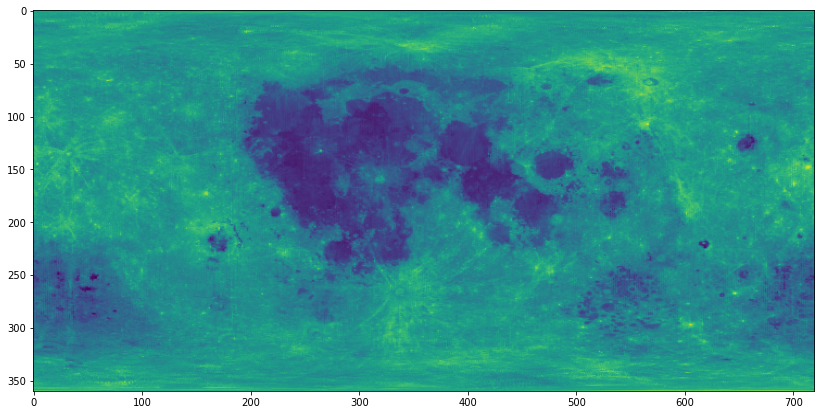

In [ ]:
albedo = np.genfromtxt('/content/drive/MyDrive/Lola_Albedo.csv', delimiter=',')
albedo = np.flip(albedo, axis = 0)

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(albedo, aspect='auto')

I'm building a numpy array called xy which stores the long and lat value for each pixel of the albedo image.

* xy's shape is (360, 720, 2)
* 0th dimension: y on the albedo image
* 1st dimension: x on the albedo image
* 2nd dimension: [0: long, 1: lat] of that particular pixel of the moon

First we need to create a range of acceptable lat/long values:

In [ ]:
x_axis = [np.arange(-180, 180, 0.5)] # 0.5 cause 720/2 = 360
y_axis = [np.arange(90, -90, -0.5)] # -0.5 cause 360/2 = 180
xx, yy = np.meshgrid(x_axis, y_axis, indexing='xy')

Making sure the arrays have the correct shape. The xx array holds the long values for each pixel and the yy array holds the lat values.

In [ ]:
np.shape(xx)

(360, 720)

We combine xx and yy into one array:

In [ ]:
xy = np.array(list(zip(xx, yy)))
xy = np.moveaxis(xy, 1, -1) # reorder the axes
np.shape(xy)

(360, 720, 2)

Example usage:

In [ ]:
xy[150, 150, :] # returns long and lat values for the pixel at position [150, 150] 

array([-105.,   15.])

The idea behind my adaptive blurring function is this:

1.   Calculate the distance (in kilometers) from each pixel to the pixel right next to it
2.   Using these distances, calculate the proper guassian blur radius (in pixels) for each pixel

Essentialy, the algorithm starts at the pixel located at [0, 0] and iterates through all pixels. For each of them it calculates the correct gaussian blur radius based on the kilometers parameter. For example, if we need to blur with a radius of 150 km, the algorithm will calculate how many pixels $p$ correspond to 150km depending on the current lat/long and then apply a gaussian covolution centered around the current pixel with radius = $p$.





Haversine calculation:

In [ ]:
# I found that online but I edited it a bit for clarity

from math import radians, cos, sin, asin, sqrt
def haversine(lat1, lon1, lat2, lon2, radius):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 

    km = radius * c
    return km

In [ ]:
print(haversine(90, 0, -90, 0, 1739))
print(haversine(0, -180, 0, 0, 1739)*2)

5463.22962459265
10926.4592491853


Creating an array that, for each pixel, tells us its distance in kilometers from the pixels next to it

In [ ]:
# xy's shape is (360, 720, 2)
# 0th dimension: y on the albedo
# 1st dimension: x on the albedo
# 2nd dimension: [0: long, 1: lat]

distances = np.empty((360, 720, 2))

# traverse the entire albedo
for i in range(np.shape(xy)[0]-1): # 0 to 358 in this case (y axis)
    for j in range(np.shape(xy)[1]-1): # 0 to 718 in this case (x axis)
        # calculate pixel height in km using the pixel below the current one
        # reminder: haversine(lat1, lon1, lat2, lon2, radius)
        distances[i, j, 1] = haversine(xy[i, j, 1], xy[i, j, 0], xy[i+1, j, 1], xy[i+1, j, 0], 1739)
        # calculate pixel width in km using the pixel to the right of the current one
        distances[i, j, 0] = haversine(xy[i, j, 1], xy[i, j, 0], xy[i, j+1, 1], xy[i, j+1, 0], 1739)

# the method above fails to calculate values for the last row and last column
# we do that here:

# fixing the last row
for j in range(np.shape(xy)[1]): # 0 to 719 in this case (x axis)       
    distances[-1, j, 1] = haversine(xy[-1, j, 1], xy[-1, j, 0], xy[-2, j, 1], xy[-2, j, 0], 1739)

# fixing the last column
for i in range(np.shape(xy)[0]): # 0 to 359 in this case (y axis)
    distances[i, -1, 0] = haversine(xy[i, -1, 1], xy[i, -1, 0], xy[i, -2, 1], xy[i, -2, 0], 1739)

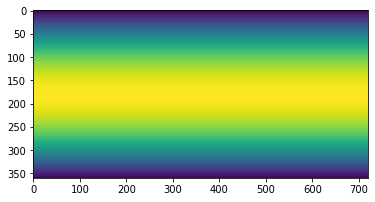

In [ ]:
plt.imshow(distances[:,:,0])

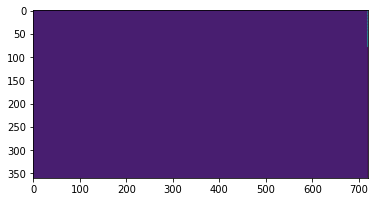

In [ ]:
plt.imshow(distances[:,:,1])

We notice that only one of the coordinates affects the pixel size in kilometers. That makes sense since the "distortion" of the map changes depending on our latitude but remains the same if we move only across the X axis.

Functions for turning km distances to pixels and for creating gaussian filters:

In [ ]:
import math
radius = 3
sigma = 1

# diastances' shape is (360, 720, 2)
# 0th dimension: y on the albedo
# 1st dimension: x on the albedo
# 2nd dimension: [0: dist long, 1: dist lat]

def km_to_radius_x(km, x, y):
    '''Turns distances in km to distances in pixels'''
    # the reason this function is bounded to 1440 is that the values for radius
    # on the poles go to infinity and break the algorithm
    if y == 0 or y == 359: return 1440
    distance = distances[y, x, 0] 
    increment = int(km/distance) 
    
    return increment if increment < 1440 else 1440


def create_filter_2d_sep(radius, sigma):
    '''Create a 2D gaussian filter using the separabily property of the Gaussian kernel'''
    gauss = np.empty([2*radius+1, 1])
    center = int(radius)
    
    for pixel in range(2*radius+1):
    # Create a 1D matrix which essentialy is the Gaussian blur in one dimension
        x = abs(center-pixel)
        gaussian = (1/(math.sqrt(2*math.pi*sigma**2))) * (math.e ** ((-x**2)/(2*(sigma**2))))
        gauss[pixel] = gaussian

    # Inner product of the matrix with its transpose is mathematically equivalent
    # to the 2D gaussian kernel but executes faster
    gauss2d = gauss @ gauss.T

    return gauss2d/np.sum(gauss2d)

Adaptive blur function:

In [ ]:
def adaptive_gauss(km, sigma, img):
    '''Adaptive gaussian blurring'''
    lat, lon = np.shape(img)
    fail = []

    albd = np.concatenate((img, img, img, img, img), axis=1)
    pad = 1440

    for y in range(lat):
        radius = km_to_radius_x(km, 15, y)
        filter = create_filter_2d_sep(radius, sigma)
        # print(y)
        # print(radius)

        for x in range(pad, pad+lon):

            # general case
            uplim = y-radius
            downlim = y+radius+1
            leftlim = x-radius
            rightlim = x+radius+1

            fuplim = 0
            fdownlim = 2*radius+1
            fleftlim = 0
            frightlim = 2*radius+1         

            # edge cases
            if y-radius < 0:
                uplim = 0
                fuplim = abs(y-radius)

            if y+radius > 359:
                downlim = 359
                fdownlim = 359-y+radius

            a = albd[uplim:downlim, leftlim:rightlim]
            b = filter[fuplim:fdownlim, fleftlim:frightlim]
            try:
                img[y, x-pad] = np.sum(np.multiply(a, b))
            except Exception as e:
                if y not in fail: fail.append(y)
                print(e)
                # print(y, x, np.shape(a), np.shape(b))

    if fail: print(fail)
    return img               

Testing for a radius in km = 120

In [ ]:
alb_test = np.array(albedo, copy=True)  
test = adaptive_gauss(120, 20, alb_test)

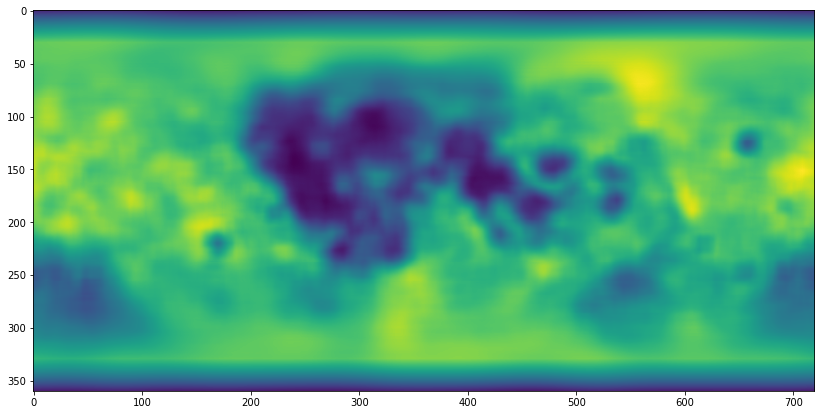

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(test, aspect='auto')

# alb = cv2.GaussianBlur(albedo, (21, 21), 20)
# fig, ax = plt.subplots(figsize=(14, 7))
# ax.imshow(alb, aspect='auto')

The way it looks makes sense to me, since the top and bottom of the map are the poles. So it makes sense for them to turn into a uniform-ish color. 

For $r$ = 20km

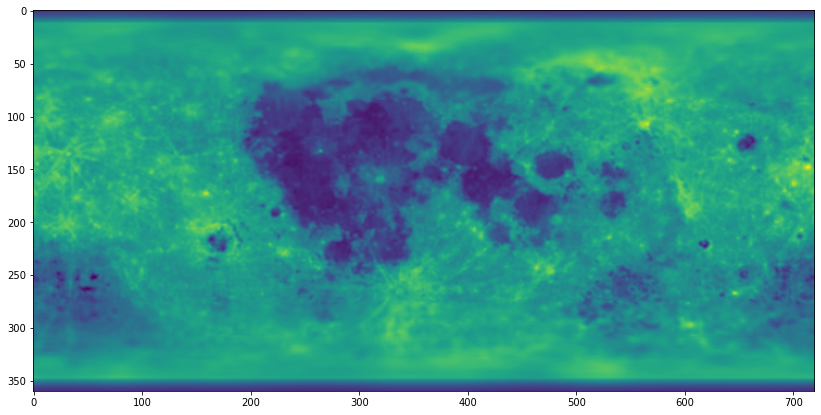

In [ ]:
alb_test = np.array(albedo, copy=True)  
test = adaptive_gauss(20, 20, alb_test)

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(test, aspect='auto')

# alb = cv2.GaussianBlur(albedo, (21, 21), 20)
# fig, ax = plt.subplots(figsize=(14, 7))
# ax.imshow(alb, aspect='auto')

Plotting the change of the radius (in pixels) in relation to the latitude of the pixel

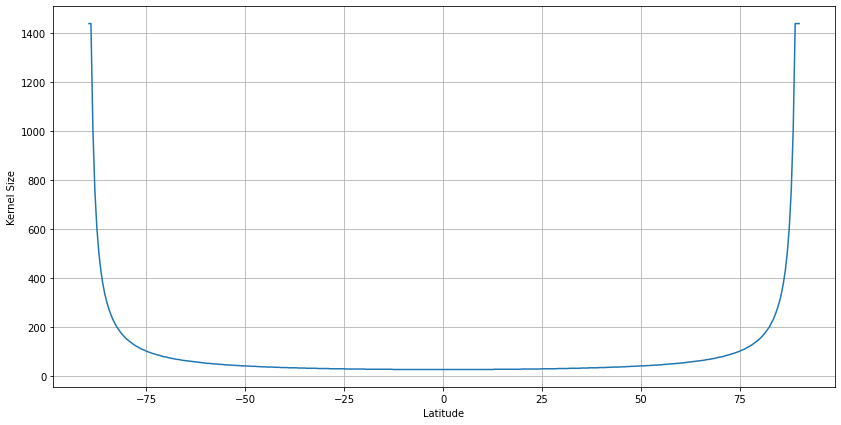

In [ ]:
radii = []

for y in range(360):
    radius = km_to_radius_x(400, 250, y)
    radii.append(radius)

fig, ax = plt.subplots(figsize=(14, 7))
plt.ylabel("Kernel Size")
plt.xlabel("Latitude")
plt.grid()
ax.plot(np.arange(90, -90, -0.5), radii)

## Preparing the moon data

Loading Moon's element maps:

In [ ]:
moon_path = '/content/drive/MyDrive/Moon/' # file path
moon_files = os.listdir(moon_path) # get all files names in this path

moon = {} # storing the maps in a dictionary of numpy arrays
for f in moon_files: 
    file_name = f.split('_')[0] # files are named in the format Element_map, we keep the first part
    moon[file_name] = np.genfromtxt(moon_path + f, delimiter=',')

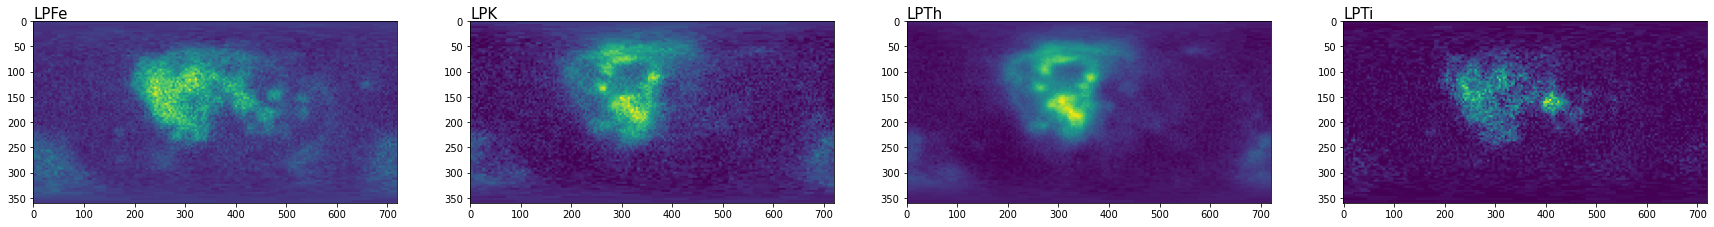

In [ ]:
maps = ['LPFe', 'LPK', 'LPTh', 'LPTi'] # the maps we care about

fig, axs = plt.subplots(1, len(maps), figsize=(30, 10))

for m in range(len(maps)):
    axs[m].imshow(moon[maps[m]]) # display the map
    axs[m].text(0, -5, maps[m], fontsize=15) # display a label over the map

plt.show()

Splitting everything into train and test. The `map_splitter` method used, is one of my custom helper functions that are defined above.

In [ ]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()

for m in maps:
    left, right = map_splitter(moon[m]) # split and flatten each map
    X_train = pd.concat([X_train, left], axis = 1)
    X_test = pd.concat([X_test, right], axis = 1)

X_train.columns = maps
X_test.columns = maps
X_train

LPFe     LPK     LPTh      LPTi
0       4.04409  788.81  1.26750  0.190154
1       4.04409  788.81  1.26750  0.190154
2       4.04409  788.81  1.26750  0.190154
3       4.04409  788.81  1.26750  0.190154
4       4.04409  788.81  1.26750  0.190154
...         ...     ...      ...       ...
129595  3.82753  455.07  0.79856  0.112137
129596  3.82753  455.07  0.79856  0.112137
129597  3.82753  455.07  0.79856  0.112137
129598  3.82753  455.07  0.79856  0.112137
129599  3.82753  455.07  0.79856  0.112137

[129600 rows x 4 columns]

## Experiments where radius = pixels

I'm using the `GaussianBlur` method from the `cv2` module. First, I plot different values of σ (sigma) against different metrics. Once I find the value where the plot "plateaus", I use that value of sigma to calculate the optimal kernel size. Essentially, I'm using these plots like elbow plots.

In [ ]:
mses, rmses, maes, rsqs, residuals = ([] for i in range(5))

y_train, y_test = map_splitter(albedo)
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, n_estimators = 30, max_depth = 5)

srange = [x/10 for x in range(2, 100, 2)]
for s in srange:
    alb = cv2.GaussianBlur(albedo, (0, 0), s)
    y_trains, y_tests = map_splitter(alb) 
    xgb_reg.fit(X_train, np.ravel(y_trains))
    pred = xgb_reg.predict(X_test)
    mse, rmse, mae, rsq, residual = map_scoring(y_tests, pred.reshape(-1, 1), verbose=False, plots=False)

    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)
    rsqs.append(rsq)
    residuals.append(residual.mean())

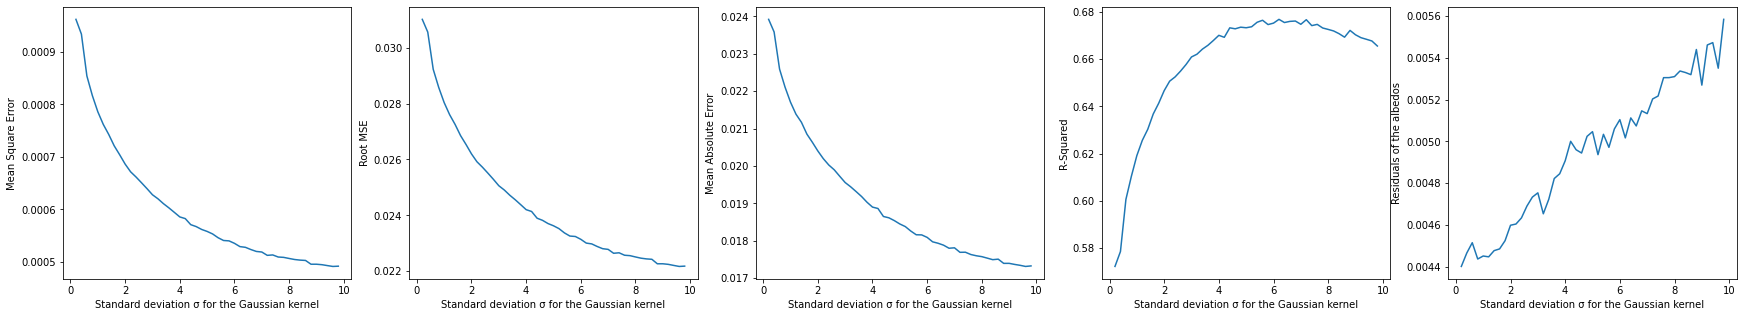

In [ ]:
helper_sigmas(srange, mses, rmses, maes, rsqs, residuals)

The best value for sigma seems to be 5. Below, I'm searching for the optimal value of the kernel size for σ=5.

In [ ]:
mses, rmses, maes, rsqs, residuals = ([] for i in range(5))

y_train, y_test = map_splitter(albedo)
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, n_estimators = 30, max_depth = 5)

srange = [x for x in range(1, 100, 2)]
for s in srange:
    alb = cv2.GaussianBlur(albedo, (s, s), 5)
    y_trains, y_tests = map_splitter(alb) 
    xgb_reg.fit(X_train, np.ravel(y_trains))
    pred = xgb_reg.predict(X_test)
    mse, rmse, mae, rsq, residual = map_scoring(y_tests, pred.reshape(-1, 1), verbose=False, plots=False)

    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)
    rsqs.append(rsq)
    residuals.append(residual.mean())

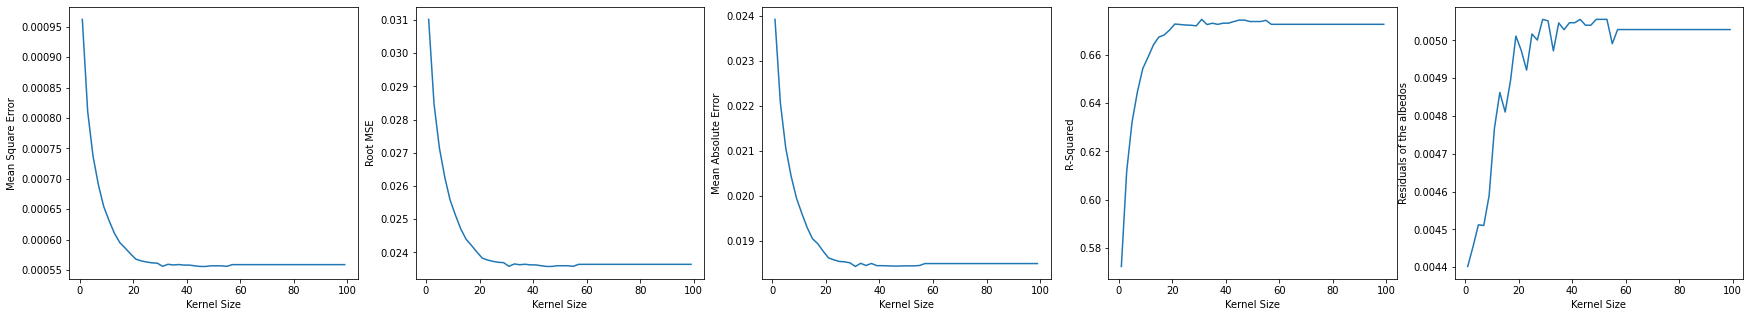

In [ ]:
helper_ksize(srange, mses, rmses, maes, rsqs, residuals)

Running the same experiment again but with a shorter range of values.

In [ ]:
mses, rmses, maes, rsqs, residuals = ([] for i in range(5))

y_train, y_test = map_splitter(albedo)
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, n_estimators = 30, max_depth = 5)

srange = [x for x in range(11, 40, 2)]
for s in srange:
    alb = cv2.GaussianBlur(albedo, (s, s), 5)
    y_trains, y_tests = map_splitter(alb) 
    xgb_reg.fit(X_train, np.ravel(y_trains))
    pred = xgb_reg.predict(X_test)
    mse, rmse, mae, rsq, residual = map_scoring(y_tests, pred.reshape(-1, 1), verbose=False, plots=False)

    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)
    rsqs.append(rsq)
    residuals.append(residual.mean())

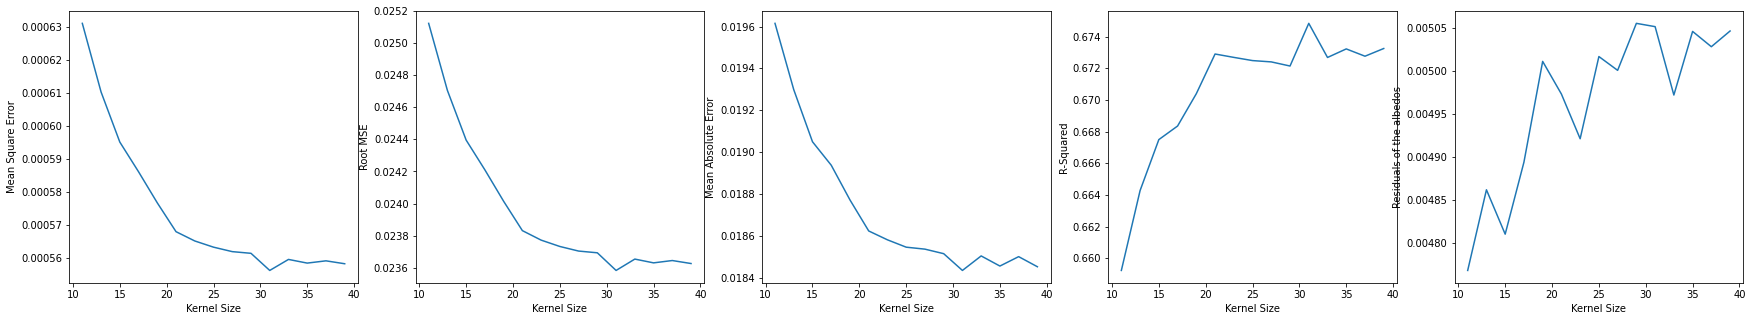

In [ ]:
helper_ksize(srange, mses, rmses, maes, rsqs, residuals)

MSE:0.0009698319942023454
RMSE:0.031142125717464206
MAE:0.024037428394097973
r^2:0.5687926583565348


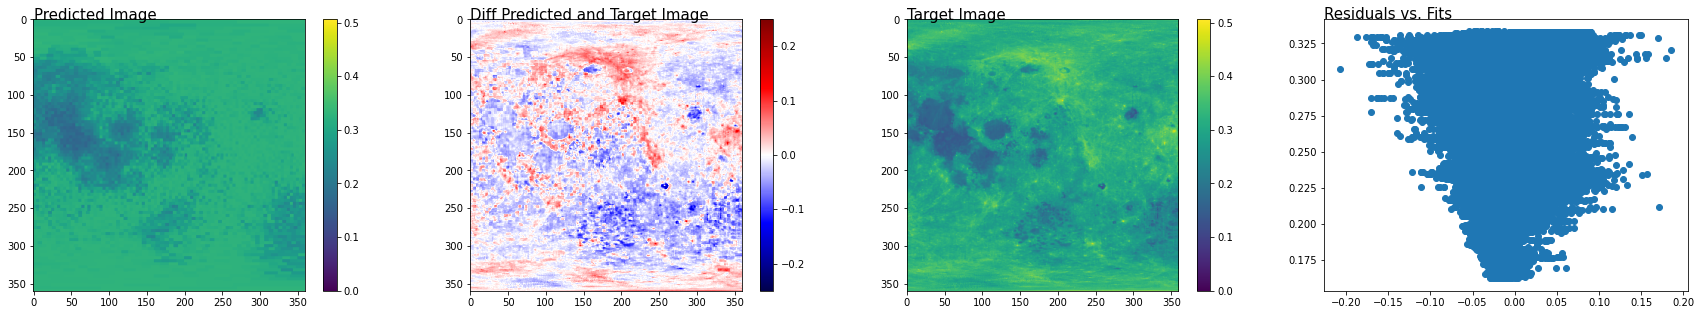

In [ ]:
y_trains, y_tests = map_splitter(albedo) 
map_scoring(y_test, pred.reshape(-1, 1));

MSE:0.0005590588101547927
RMSE:0.023644424504622494
MAE:0.018467258473264754
r^2:0.6731395681105473


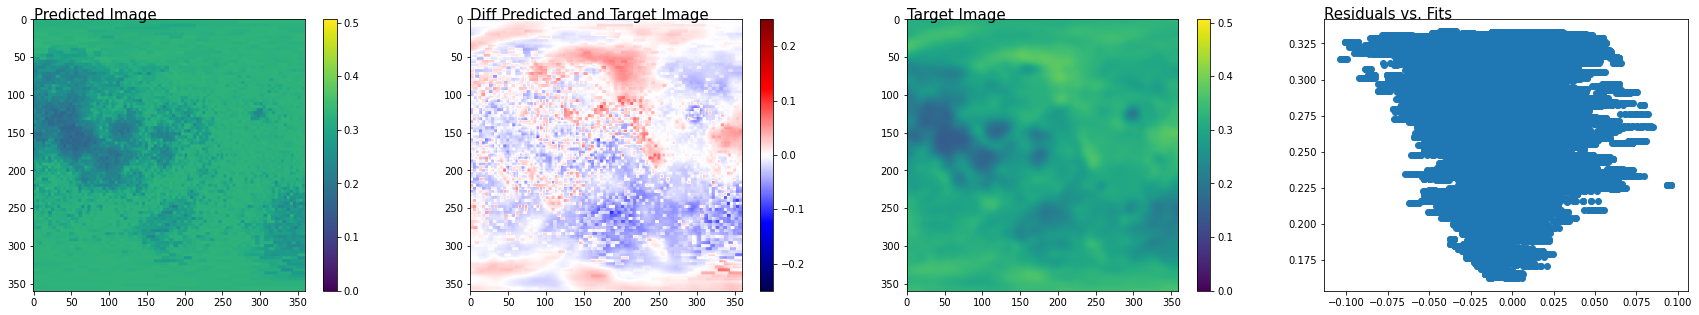

In [ ]:
alb = cv2.GaussianBlur(albedo, (31, 31), 5)
y_trains, y_tests = map_splitter(alb) 
map_scoring(y_tests, pred.reshape(-1, 1));

Our metrics have improved. Also, the difference between target and predicted image doesn't have clear features but looks more like noise than anything else. Next, I'll repeat the same experiments for polynomial regression. I did some grid search CV in a local environment and determined that the best poly degree is 2.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression())])

mses, rmses, maes, rsqs, residuals = ([] for i in range(5))

y_train, y_test = map_splitter(albedo)

srange = [x/10 for x in range(2, 100, 2)]
for s in srange:
    alb = cv2.GaussianBlur(albedo, (0, 0), s)
    y_trains, y_tests = map_splitter(alb) 
    pipe.fit(X_train, np.ravel(y_trains))
    pred = pipe.predict(X_test)
    mse, rmse, mae, rsq, residual = map_scoring(y_tests, pred.reshape(-1, 1), verbose=False, plots=False)

    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)
    rsqs.append(rsq)
    residuals.append(residual.mean())

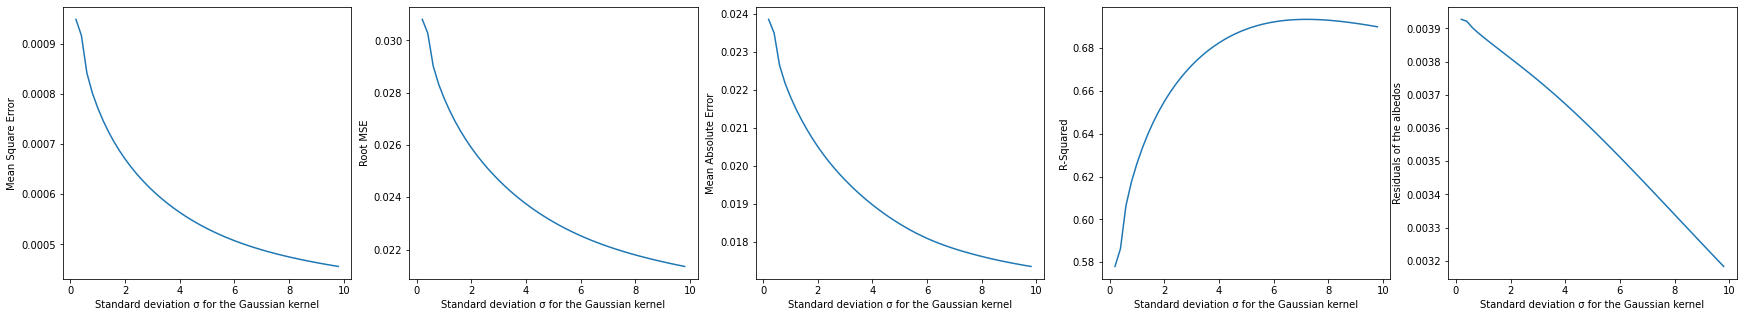

In [ ]:
helper_sigmas(srange, mses, rmses, maes, rsqs, residuals)

In [ ]:
mses, rmses, maes, rsqs, residuals = ([] for i in range(5))

y_train, y_test = map_splitter(albedo)

pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression())])

srange = [x for x in range(11, 40, 2)]
for s in srange:
    alb = cv2.GaussianBlur(albedo, (s, s), 5)
    y_trains, y_tests = map_splitter(alb) 
    pipe.fit(X_train, np.ravel(y_trains))
    pred = pipe.predict(X_test)
    mse, rmse, mae, rsq, residual = map_scoring(y_tests, pred.reshape(-1, 1), verbose=False, plots=False)

    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)
    rsqs.append(rsq)
    residuals.append(residual.mean())

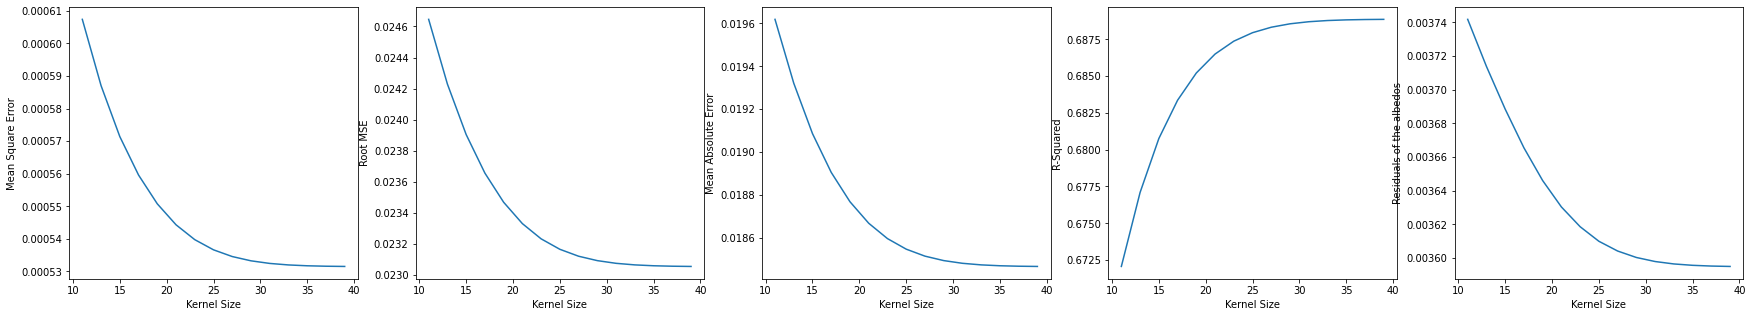

In [ ]:
helper_ksize(srange, mses, rmses, maes, rsqs, residuals)

MSE:0.0009464541049784104
RMSE:0.030764494225948368
MAE:0.023805072154048406
r^2:0.5791869508997288


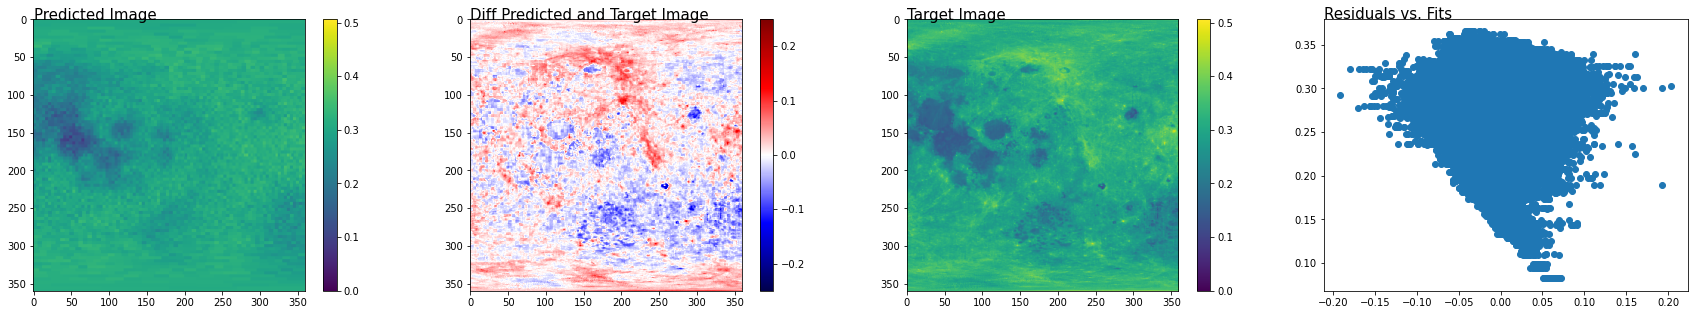

In [ ]:
y_trains, y_tests = map_splitter(albedo) 
map_scoring(y_tests, pred.reshape(-1, 1));

## Best result when radius = pixels

MSE:0.0005324020846172776
RMSE:0.02307383983253064
MAE:0.018479305115882944
r^2:0.688724742091686


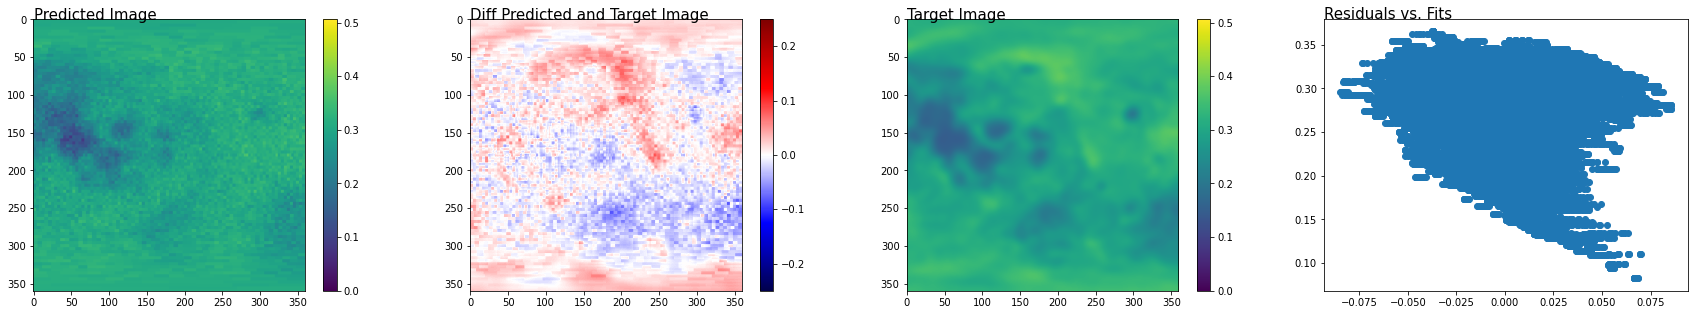

In [ ]:
alb = cv2.GaussianBlur(albedo, (31, 31), 5)
y_trains, y_tests = map_splitter(alb) 
map_scoring(y_tests, pred.reshape(-1, 1));

## Experiments where radius = km

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression())])

mses, rmses, maes, rsqs, residuals = ([] for i in range(5))

y_train, y_test = map_splitter(albedo)

kmrange = range(10, 500, 10)

for km in kmrange:
    alb_test = np.array(albedo, copy=True)  
    alb = adaptive_gauss(km, 2, alb_test)

    y_trains, y_tests = map_splitter(alb) 
    pipe.fit(X_train, np.ravel(y_trains))
    pred = pipe.predict(X_test)
    mse, rmse, mae, rsq, residual = map_scoring(y_tests, pred.reshape(-1, 1), verbose=False, plots=False)

    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)
    rsqs.append(rsq)
    residuals.append(residual.mean())

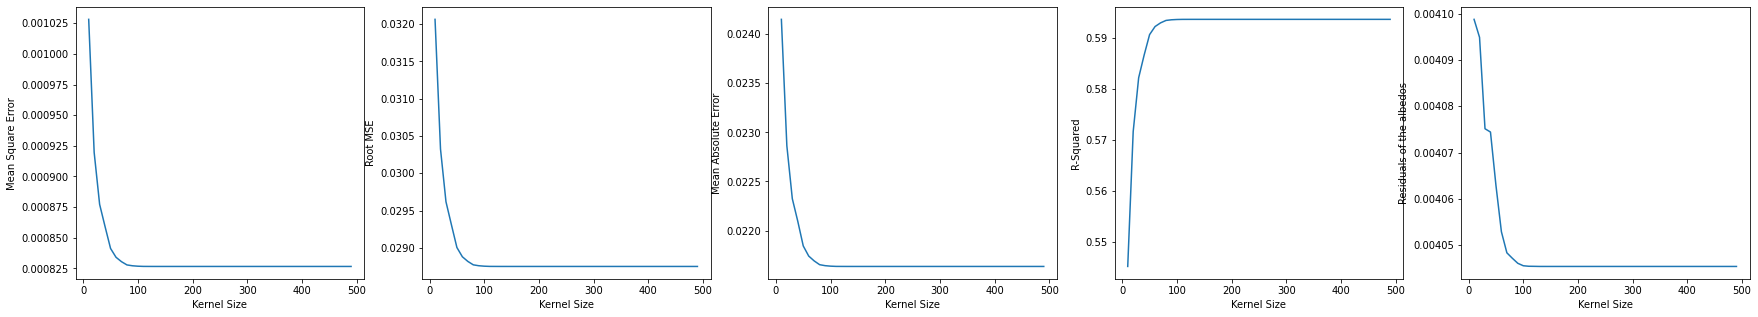

In [ ]:
helper_ksize(kmrange, mses, rmses, maes, rsqs, residuals)

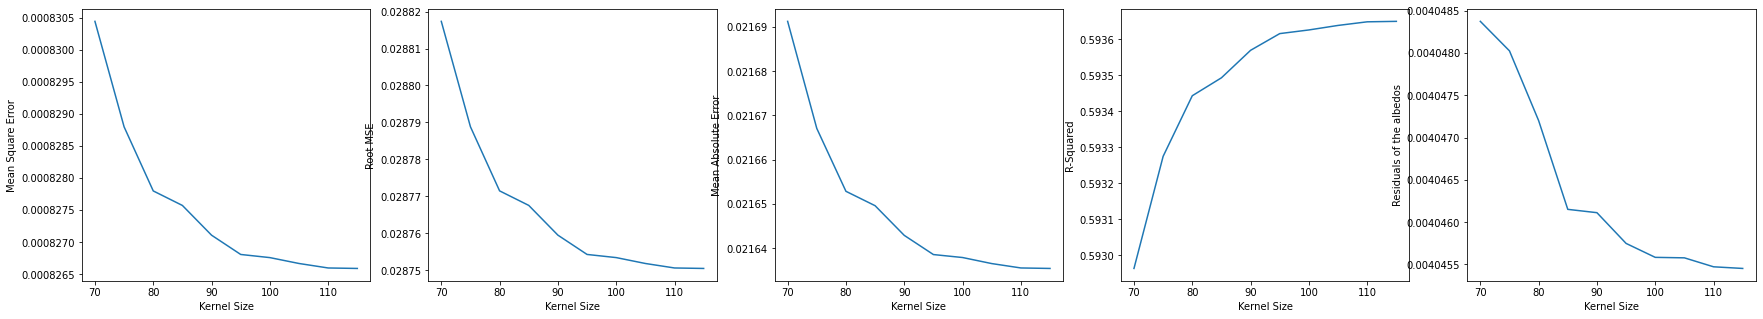

In [ ]:
pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression())])

mses, rmses, maes, rsqs, residuals = ([] for i in range(5))

y_train, y_test = map_splitter(albedo)

kmrange = range(70, 120, 5)

for km in kmrange:
    alb_test = np.array(albedo, copy=True)  
    alb = adaptive_gauss(km, 2, alb_test)

    y_trains, y_tests = map_splitter(alb) 
    pipe.fit(X_train, np.ravel(y_trains))
    pred = pipe.predict(X_test)
    mse, rmse, mae, rsq, residual = map_scoring(y_tests, pred.reshape(-1, 1), verbose=False, plots=False)

    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)
    rsqs.append(rsq)
    residuals.append(residual.mean())

helper_ksize(kmrange, mses, rmses, maes, rsqs, residuals)

## Best result when radius = km

MSE:0.0009294042998776077
RMSE:0.030486132911171394
MAE:0.021674894425318624
r^2:0.5546456924988225


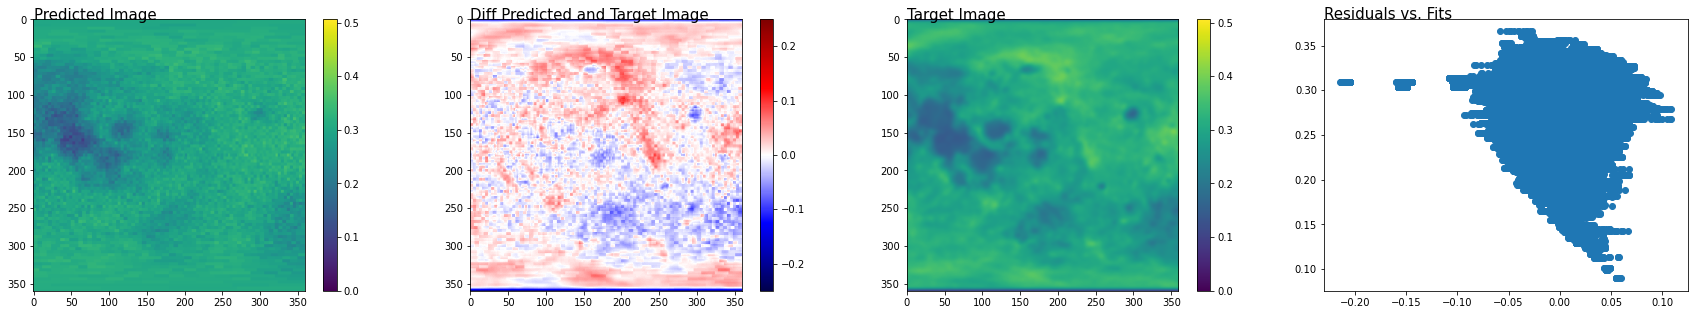

In [ ]:
alb = adaptive_gauss(95, 2, alb_test)
y_trains, y_tests = map_splitter(alb) 
map_scoring(y_tests, pred.reshape(-1, 1));

## Mercury Masks

In [ ]:
mercury_path = '/content/drive/MyDrive/Mercury/' # file path
mercury_files = os.listdir(mercury_path) # get the names of all files in path

mercury = {} # again "saving" map data in a dictionary of np.arrays
for f in mercury_files: 
    file_name = re.split('(_|\.)', f)[0] # regex to get rid of weird file name parts
    mercury[file_name] = np.genfromtxt(mercury_path + f, delimiter=',')

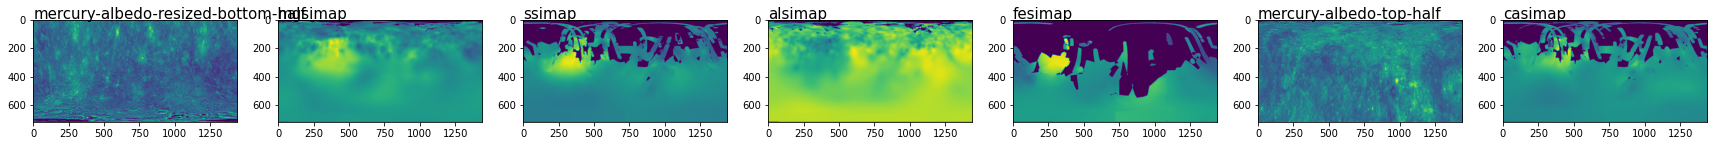

In [ ]:
maps = list(mercury.keys())
fig, axs = plt.subplots(1, len(maps), figsize=(30, 10))

for m in range(len(maps)):
    axs[m].imshow(mercury[maps[m]])
    axs[m].text(0, -5, maps[m], fontsize=15)

plt.show()

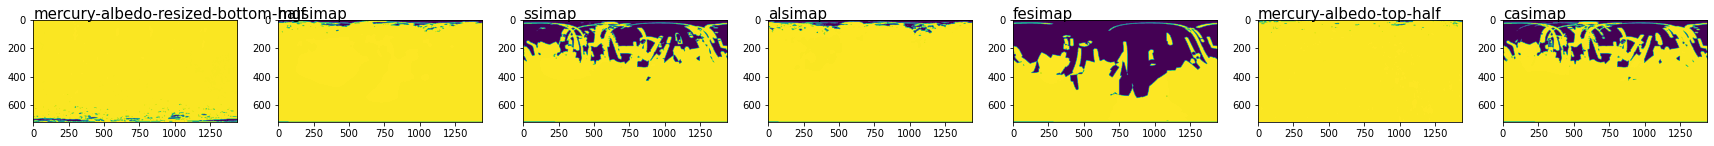

In [ ]:
fig, axs = plt.subplots(1, len(maps), figsize=(30, 10))


for m in range(len(maps)):
    axs[m].imshow(np.where(mercury[maps[m]]==0, -100, mercury[maps[m]]))
    axs[m].text(0, -5, maps[m], fontsize=15)

plt.show()

In [ ]:
maps = ['mgsimap', 'alsimap', 'ssimap', 'fesimap', 'casimap']
masks = {}

for m in range(len(maps)):
    stretched_map = np.repeat(mercury[maps[m]],2, axis=0)
    masks[maps[m]] = np.array([stretched_map == 0])[0,:,:]

masks

{'alsimap': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 'casimap': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 'fesimap': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ Tr

In [ ]:
a = np.logical_and(masks['fesimap'], masks['ssimap'])
b = np.logical_and(masks['alsimap'], a)
c = np.logical_and(masks['mgsimap'], b)
d = np.logical_and(masks['casimap'], c)

final_mask_and_full = d

In [ ]:
np.shape(final_mask_and_full)

(1440, 1440)

In [ ]:
final_mask_and = final_mask_and_full[:720,:]
np.shape(final_mask_and)

(720, 1440)

In [ ]:
masked = np.ma.array(mercury['mercury-albedo-top-half'], mask = final_mask_and)

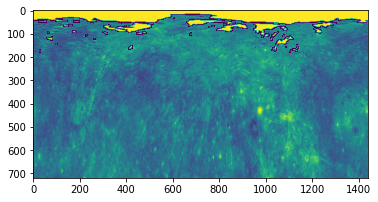

In [ ]:
plt.imshow(final_mask_and)
plt.imshow(masked)

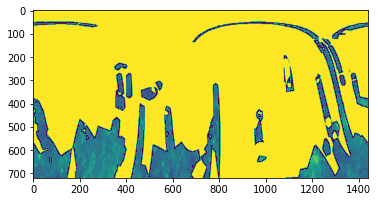

In [ ]:
a = np.logical_or(masks['fesimap'], masks['ssimap'])
b = np.logical_or(masks['alsimap'], a)
c = np.logical_or(masks['mgsimap'], b)
d = np.logical_or(masks['casimap'], c)

final_mask_or_full = d
final_mask = final_mask_or_full[:720,:]
masked = np.ma.array(mercury['mercury-albedo-top-half'], mask = final_mask)
plt.imshow(final_mask)
plt.imshow(masked)

In [ ]:
print(np.shape(final_mask))
print(np.shape(albedo))

(720, 1440)
(360, 720)


## Mooncury

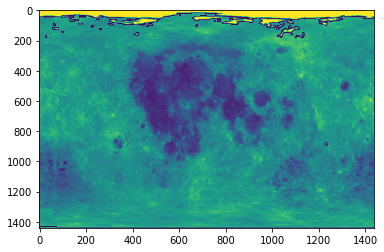

In [ ]:
aa = np.repeat(albedo, 2, axis=1)
aaa = np.repeat(aa, 4, axis=0)
plt.imshow(aaa)
np.shape(aaa)

masked = np.ma.array(aaa, mask = final_mask_and_full)
plt.imshow(final_mask_and_full, aspect='auto')
plt.imshow(masked, aspect='auto')

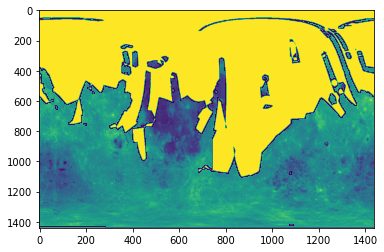

In [ ]:
masked = np.ma.array(aaa, mask = final_mask_or_full)
plt.imshow(final_mask_or_full, aspect='auto')
plt.imshow(masked, aspect='auto')

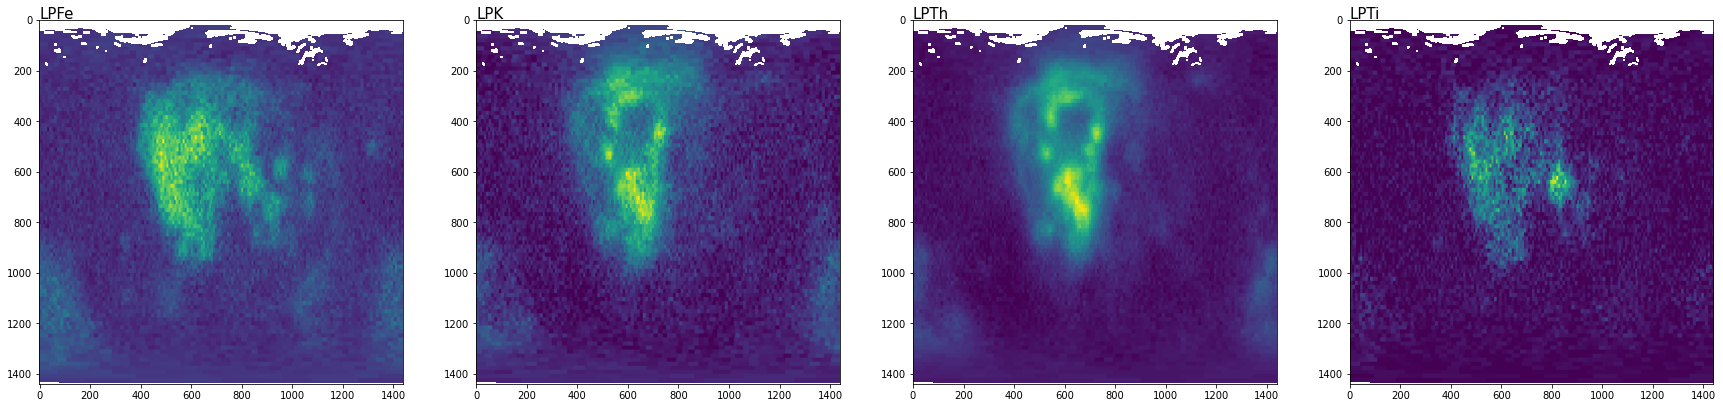

In [ ]:
maps = ['LPFe', 'LPK', 'LPTh', 'LPTi'] # the maps we care about

fig, axs = plt.subplots(1, len(maps), figsize=(30, 10))

for m in range(len(maps)):
    mapp = np.repeat(moon[maps[m]], 2, axis=1)
    mapp = np.repeat(mapp, 4, axis=0)
    axs[m].imshow(np.ma.array(mapp, mask = final_mask_and_full)) # display the map
    axs[m].text(0, -5, maps[m], fontsize=15) # display a label over the map

plt.show()

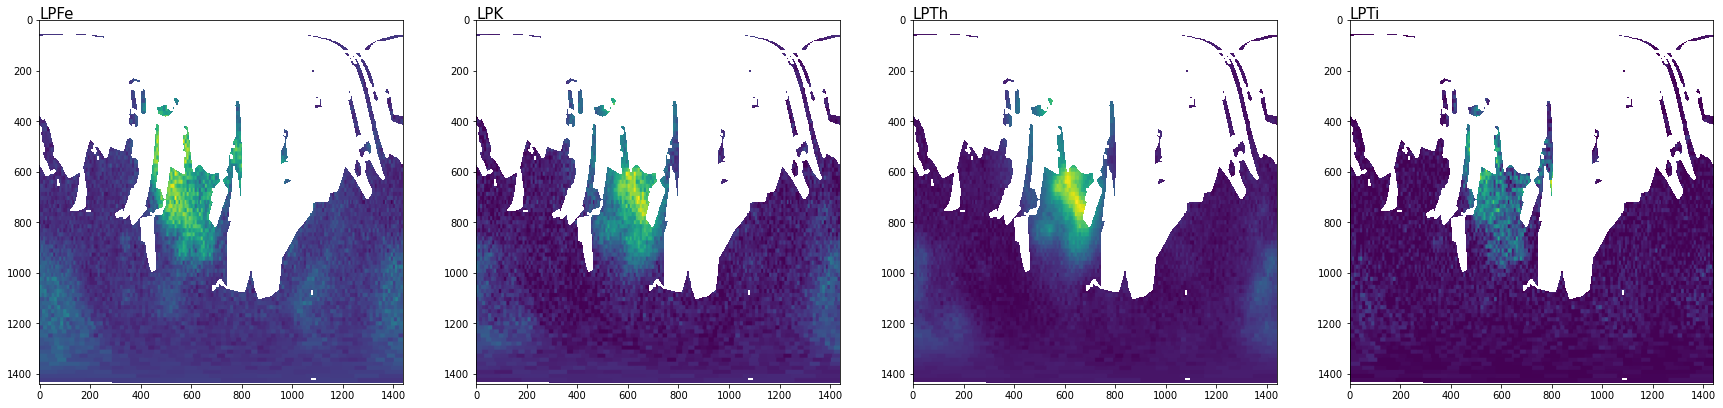

In [ ]:
maps = ['LPFe', 'LPK', 'LPTh', 'LPTi'] # the maps we care about

fig, axs = plt.subplots(1, len(maps), figsize=(30, 10))

for m in range(len(maps)):
    mapp = np.repeat(moon[maps[m]], 2, axis=1)
    mapp = np.repeat(mapp, 4, axis=0)
    axs[m].imshow(np.ma.array(mapp, mask = final_mask_or_full)) # display the map
    axs[m].text(0, -5, maps[m], fontsize=15) # display a label over the map

plt.show()